In [2]:

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets
from torch.nn import MSELoss
from torch import optim
import matplotlib.pyplot as plt
import Fresnel_Holo
import numpy as np
import time
import os
import cv2

In [3]:

# В этой директории лежат папки holo_seq, qr_seq, fren_seq, model_{data}
DATAPATH = 'D:/QR_holograms/QR_v7/'
MODEL_NAME = 'model_23_01_2024/' # Путь, куда сохраняются эпохи модели

SAVE_DIR = DATAPATH + MODEL_NAME
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print('Директория создана')

Директория создана


In [6]:
class PadToNearestMultipleOf16():
    '''
    Unet требует размерность картинки, делящуюся на 16 в силу того, что там идет понижение размерности
    вдвое 4 раза, поэтому здесь реализован padding картинки до ближайшего числа, делящегося на 16
    '''
    def __call__(self, img):
        w, h = img.shape[1:]
        w, h = torch.tensor(w), torch.tensor(h)
        target_w = int(torch.ceil(w / 16) * 16)
        target_h = int(torch.ceil(h / 16) * 16)
        padding = (0, 0, target_w - w, target_h - h)
        img = transforms.functional.pad(img, padding, fill=1)
        return img
    
normilize = normalize = transforms.Compose([
    transforms.ToTensor(),
    PadToNearestMultipleOf16(),
    transforms.Normalize(mean=[0.], std=[255.])  # Divide each pixel value by 255
])
    

In [4]:
class qr_dataset(Dataset):
    def __init__(self, data_path, regime, transform = None):
        self.data_path = data_path
        self.transform = transform
        self.regime = regime
        self.names = os.listdir(data_path + 'holo_seq/'+self.regime)
    def __getitem__(self, index):
        x = cv2.imread(DATAPATH + 'holo_seq/' + self.regime + self.names[index], cv2.IMREAD_GRAYSCALE).astype(float)
        y = cv2.imread(DATAPATH + 'qr_seq/'+ self.regime + self.names[index], cv2.IMREAD_GRAYSCALE).astype(float)
        y_fren = cv2.imread(DATAPATH + 'fren_seq/'+ self.regime + self.names[index], cv2.IMREAD_GRAYSCALE).astype(float)
        
        if self.transform:
            return self.transform(y), self.transform(x), self.transform(y_fren)
        return y, x, y_fren
    def __len__(self):
        return len(self.names)

In [5]:
def accuracy_images(image1, image2):
    i1 = torch.sum(image1*image2)
    i2 = torch.sum(image1**2)
    i3 = torch.sum(image2**2)
    return i1/torch.sqrt(i2*i3)

In [22]:
train_dataset = qr_dataset(DATAPATH, regime = 'train/', transform=normalize)
val_dataset = qr_dataset(DATAPATH, regime = 'val/', transform=normilize)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [28]:
y,x,fren = next(iter(train_loader))
x.shape

torch.Size([16, 1, 144, 144])

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [33]:
from my_unet import UNet
my_unet = UNet(1,1,64)
my_unet.to(device)
optimizer = optim.Adam(my_unet.parameters(), lr=0.001,)

In [ ]:
model1 = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=64)
model1.to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.001,)
model1

In [30]:
def train_model(model, train_loader, val_loader, opt, loss_func, n_epochs):
    epoch_train_loss = []
    epoch_val_loss = []
    for epoch in range(n_epochs):
        start_time = time.time()
        batch_train_loss = []
        batch_val_loss = []
        model.train(True) # Enable Dropout/BatchNorm training behavior
        i=0
        for y_batch, x_batch, fren_batch in train_loader:
            opt.zero_grad()
            fren_batch = fren_batch.to(device).to(torch.float)
            y_batch = y_batch.to(device).to(torch.float)
            predictions = model(fren_batch)
            loss = loss_func()(predictions, y_batch)
            loss.backward()
            batch_train_loss.append(loss.item())
            opt.step()
            i+=1
            if i%10 == 0:
                print('Batch ', i)
        model.train(False)
        i = 0
        with torch.no_grad():
            for y_batch, x_batch, fren_batch in val_loader:
                fren_batch = fren_batch.to(device).to(torch.float)
                y_batch = y_batch.to(device).to(torch.float)
                predictions = model(fren_batch)
                loss = loss_func()(predictions, y_batch)
                batch_val_loss.append(loss)
                i+=1
                if i%10 == 0:
                    print('Batch ', i)
        epoch_train_loss.append(torch.mean(torch.Tensor(batch_train_loss)))
        epoch_val_loss.append(torch.mean(torch.Tensor(batch_val_loss)))
        path = os.path.join(SAVE_DIR, f'{model.__class__.__name__}_epoch{epoch+1}.pth')
        torch.save(model.cpu().state_dict(), path)
        model.cuda()
        print(f'Epoch {epoch+1} of {n_epochs} took {time.time() - start_time:.3f} s')
        print(f"\t  training loss: {epoch_train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {epoch_val_loss[-1]:.6f}")
    return epoch_train_loss, epoch_val_loss

In [34]:
unet_train_loss, unet_val_loss = train_model(my_unet, train_loader, val_loader,
                                                 optimizer, MSELoss, 10)

Batch  10
Batch  20
Batch  30
Batch  40
Batch  50
Batch  60
Batch  70
Batch  80
Batch  90
Batch  100
Batch  110
Batch  120
Batch  130
Batch  140
Batch  150
Batch  160
Batch  170
Batch  180
Batch  190
Batch  200
Batch  210
Batch  220
Batch  230
Batch  240
Batch  250
Batch  260
Batch  270
Batch  280
Batch  290
Batch  300
Batch  310
Batch  320
Batch  330
Batch  340
Batch  350
Batch  360
Batch  370
Batch  380
Batch  390
Batch  400
Batch  410
Batch  420
Batch  430
Batch  10
Batch  20
Batch  30
Batch  40
Batch  50
Batch  60
Batch  70
Batch  80
Batch  90
Batch  100
Batch  110
Batch  120
Batch  130
Batch  140
Batch  150
Batch  160
Batch  170
Batch  180
Epoch 1 of 10 took 377.178 s
	  training loss: 0.013562
	validation loss: 0.004130
Batch  10
Batch  20
Batch  30
Batch  40
Batch  50
Batch  60
Batch  70
Batch  80
Batch  90
Batch  100
Batch  110
Batch  120
Batch  130
Batch  140
Batch  150
Batch  160
Batch  170
Batch  180
Batch  190
Batch  200
Batch  210
Batch  220
Batch  230
Batch  240
Batch  25

In [41]:
model1

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

Text(0, 0.5, 'Среднеквадратичная ошибка сети')

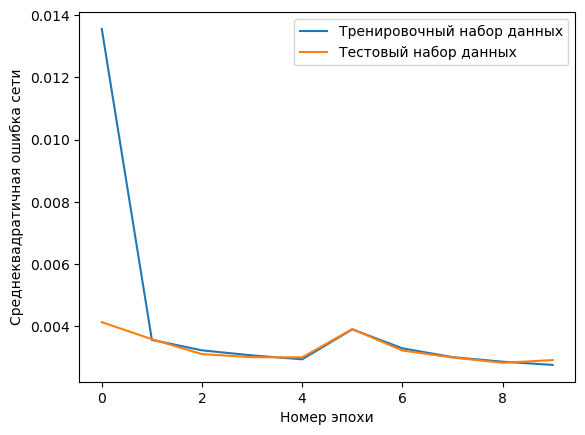

In [56]:
plt.plot(unet_train_loss, label = 'Тренировочный набор данных')
plt.plot(unet_val_loss, label = 'Тестовый набор данных')
plt.legend()
plt.xlabel('Номер эпохи')
plt.ylabel('Среднеквадратичная ошибка сети')

In [ ]:
path = os.path.join(SAVE_DIR, f'{my_unet.__class__.__name__}_epoch{1}.pth')
torch.save(my_unet.cpu().state_dict(), path)

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

Text(0.5, 1.0, 'б) Прямой расчет дифракции Френеля')

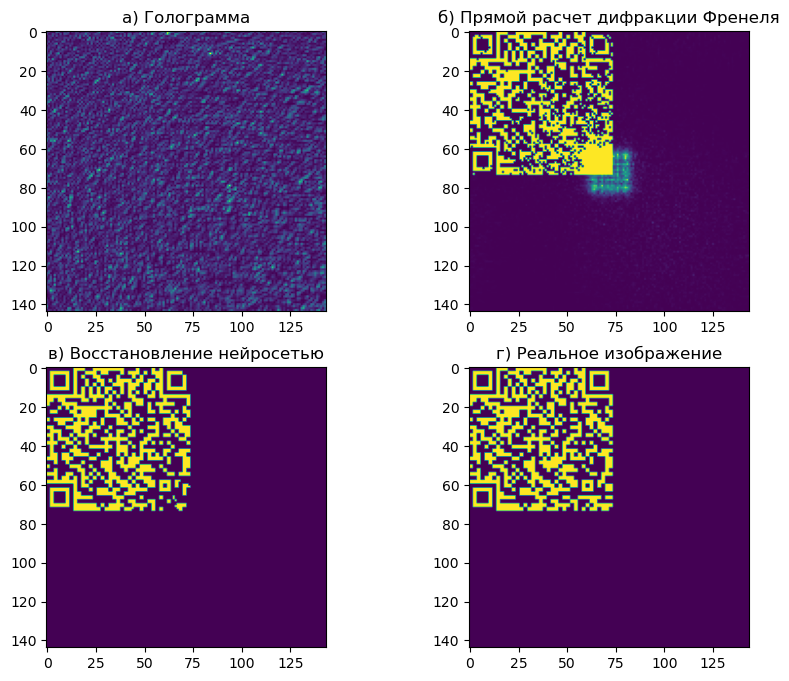

In [108]:
N_image = 8
y,x,y_fren = next(iter(val_loader))
y_fren = y_fren.to(device).to(torch.float)

fig, ax = plt.subplots(2,2, figsize = (10,8))
best_model = UNet(1,1,64)
best_model.to(device)
best_model.load_state_dict(torch.load(SAVE_DIR + '//UNet_epoch6.pth'))

bm = best_model(y_fren[N_image:N_image+1])[0][0].cpu().detach()
bm_fren_after_binarize = torch.where(bm>0.6, 1,0)

ax[1,0].imshow(bm_fren_after_binarize)
ax[1,0].set_title('в) Восстановление нейросетью')
ax[0,0].imshow(x[N_image][0].cpu())
ax[0,0].set_title('a) Голограмма')
ax[1,1].imshow(y[N_image][0])
ax[1,1].set_title('г) Реальное изображение')

a = y_fren[N_image][0].cpu()
y_fren_after_binarize = torch.where(a[0:74, 0:74]>0.008, 1,0)
a[0:74, 0:74] = y_fren_after_binarize
ax[0,1].imshow(a)
ax[0,1].set_title('б) Прямой расчет дифракции Френеля')

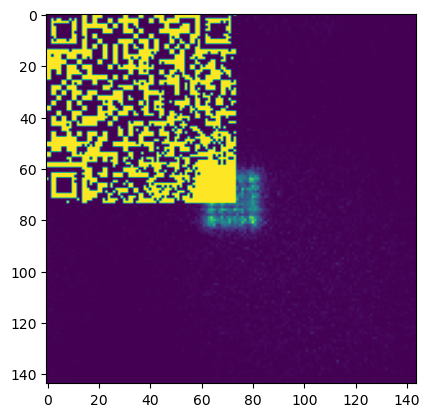

In [100]:
a = y_fren[N_image][0].cpu()
y_fren_after_binarize = torch.where(a[0:74, 0:74]>0.008, 1,0)
a[0:74, 0:74] = y_fren_after_binarize
plt.imshow(a)